In [1]:
from __future__ import print_function
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("poster",font_scale=1.2,rc={"font":"helvetica"}); 
sns.set_style("white")
sns.set_style("ticks")
cp = sns.color_palette("colorblind") #sns.palplot(current_palette)
from importlib import reload

import matplotlib
matplotlib.rc_file(matplotlib.matplotlib_fname())
%matplotlib inline
%config InlineBackend.figure_format = "retina"
#%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
#%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.weight'] = "normal"
rcParams["axes.formatter.useoffset"] = False
rcParams['xtick.major.width']=1
rcParams['xtick.major.size']=7
rcParams['xtick.minor.width']=1
rcParams['xtick.minor.size']=4
rcParams['ytick.major.width']=1
rcParams['ytick.major.size']=7
rcParams['ytick.minor.width']=1
rcParams['ytick.minor.size']=4
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'
rcParams['axes.formatter.limits'] = -10,10
import astropy.constants as aconst
import astropylib.exoplanet_functions
import astropylib.gkastro
import astropylib.nexopl
import astropylib.spec_help


>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]


Reading rvprec
Finished


In [2]:
from exotk.priors import PriorSet, UP, NP, JP, FP
import sys
sys.path.append('../src/')
import rm
rm

<module 'rm' from '../src/rm.py'>

In [51]:
ps = rm.priorset_from_file('../data/priors.dat')

In [52]:
np.array(ps.priors)[~np.array(ps.fixed)]

array([<exotk.priors.UniformPrior object at 0x7fe1147b39e8>,
       <exotk.priors.NormalPrior object at 0x7fe0e12c2a90>], dtype=object)

0.044388609715242874
Amplitude: 17.327287344855815m/s
SNR: 3.115658517281145
lambda error: 18.389621068961382
###########
toi2015_vsini_3.2_ntransits_1.png
###########
Chi2: 60.35489096725878
Chi2 reduced: 1.3120628471143214
DOF: 46
Assuming the model is correct, there is 7.604% chance
that this chi2 value or larger could arise by chance
If p value is low, model is ruled out. If p value is high, supports model
Chi2: 46.422223818375265
Chi2 reduced: 1.009178778660332
DOF: 46
Assuming the model is correct, there is 45.485% chance
that this chi2 value or larger could arise by chance
If p value is low, model is ruled out. If p value is high, supports model
3.7326488113514666 3.115658517281145


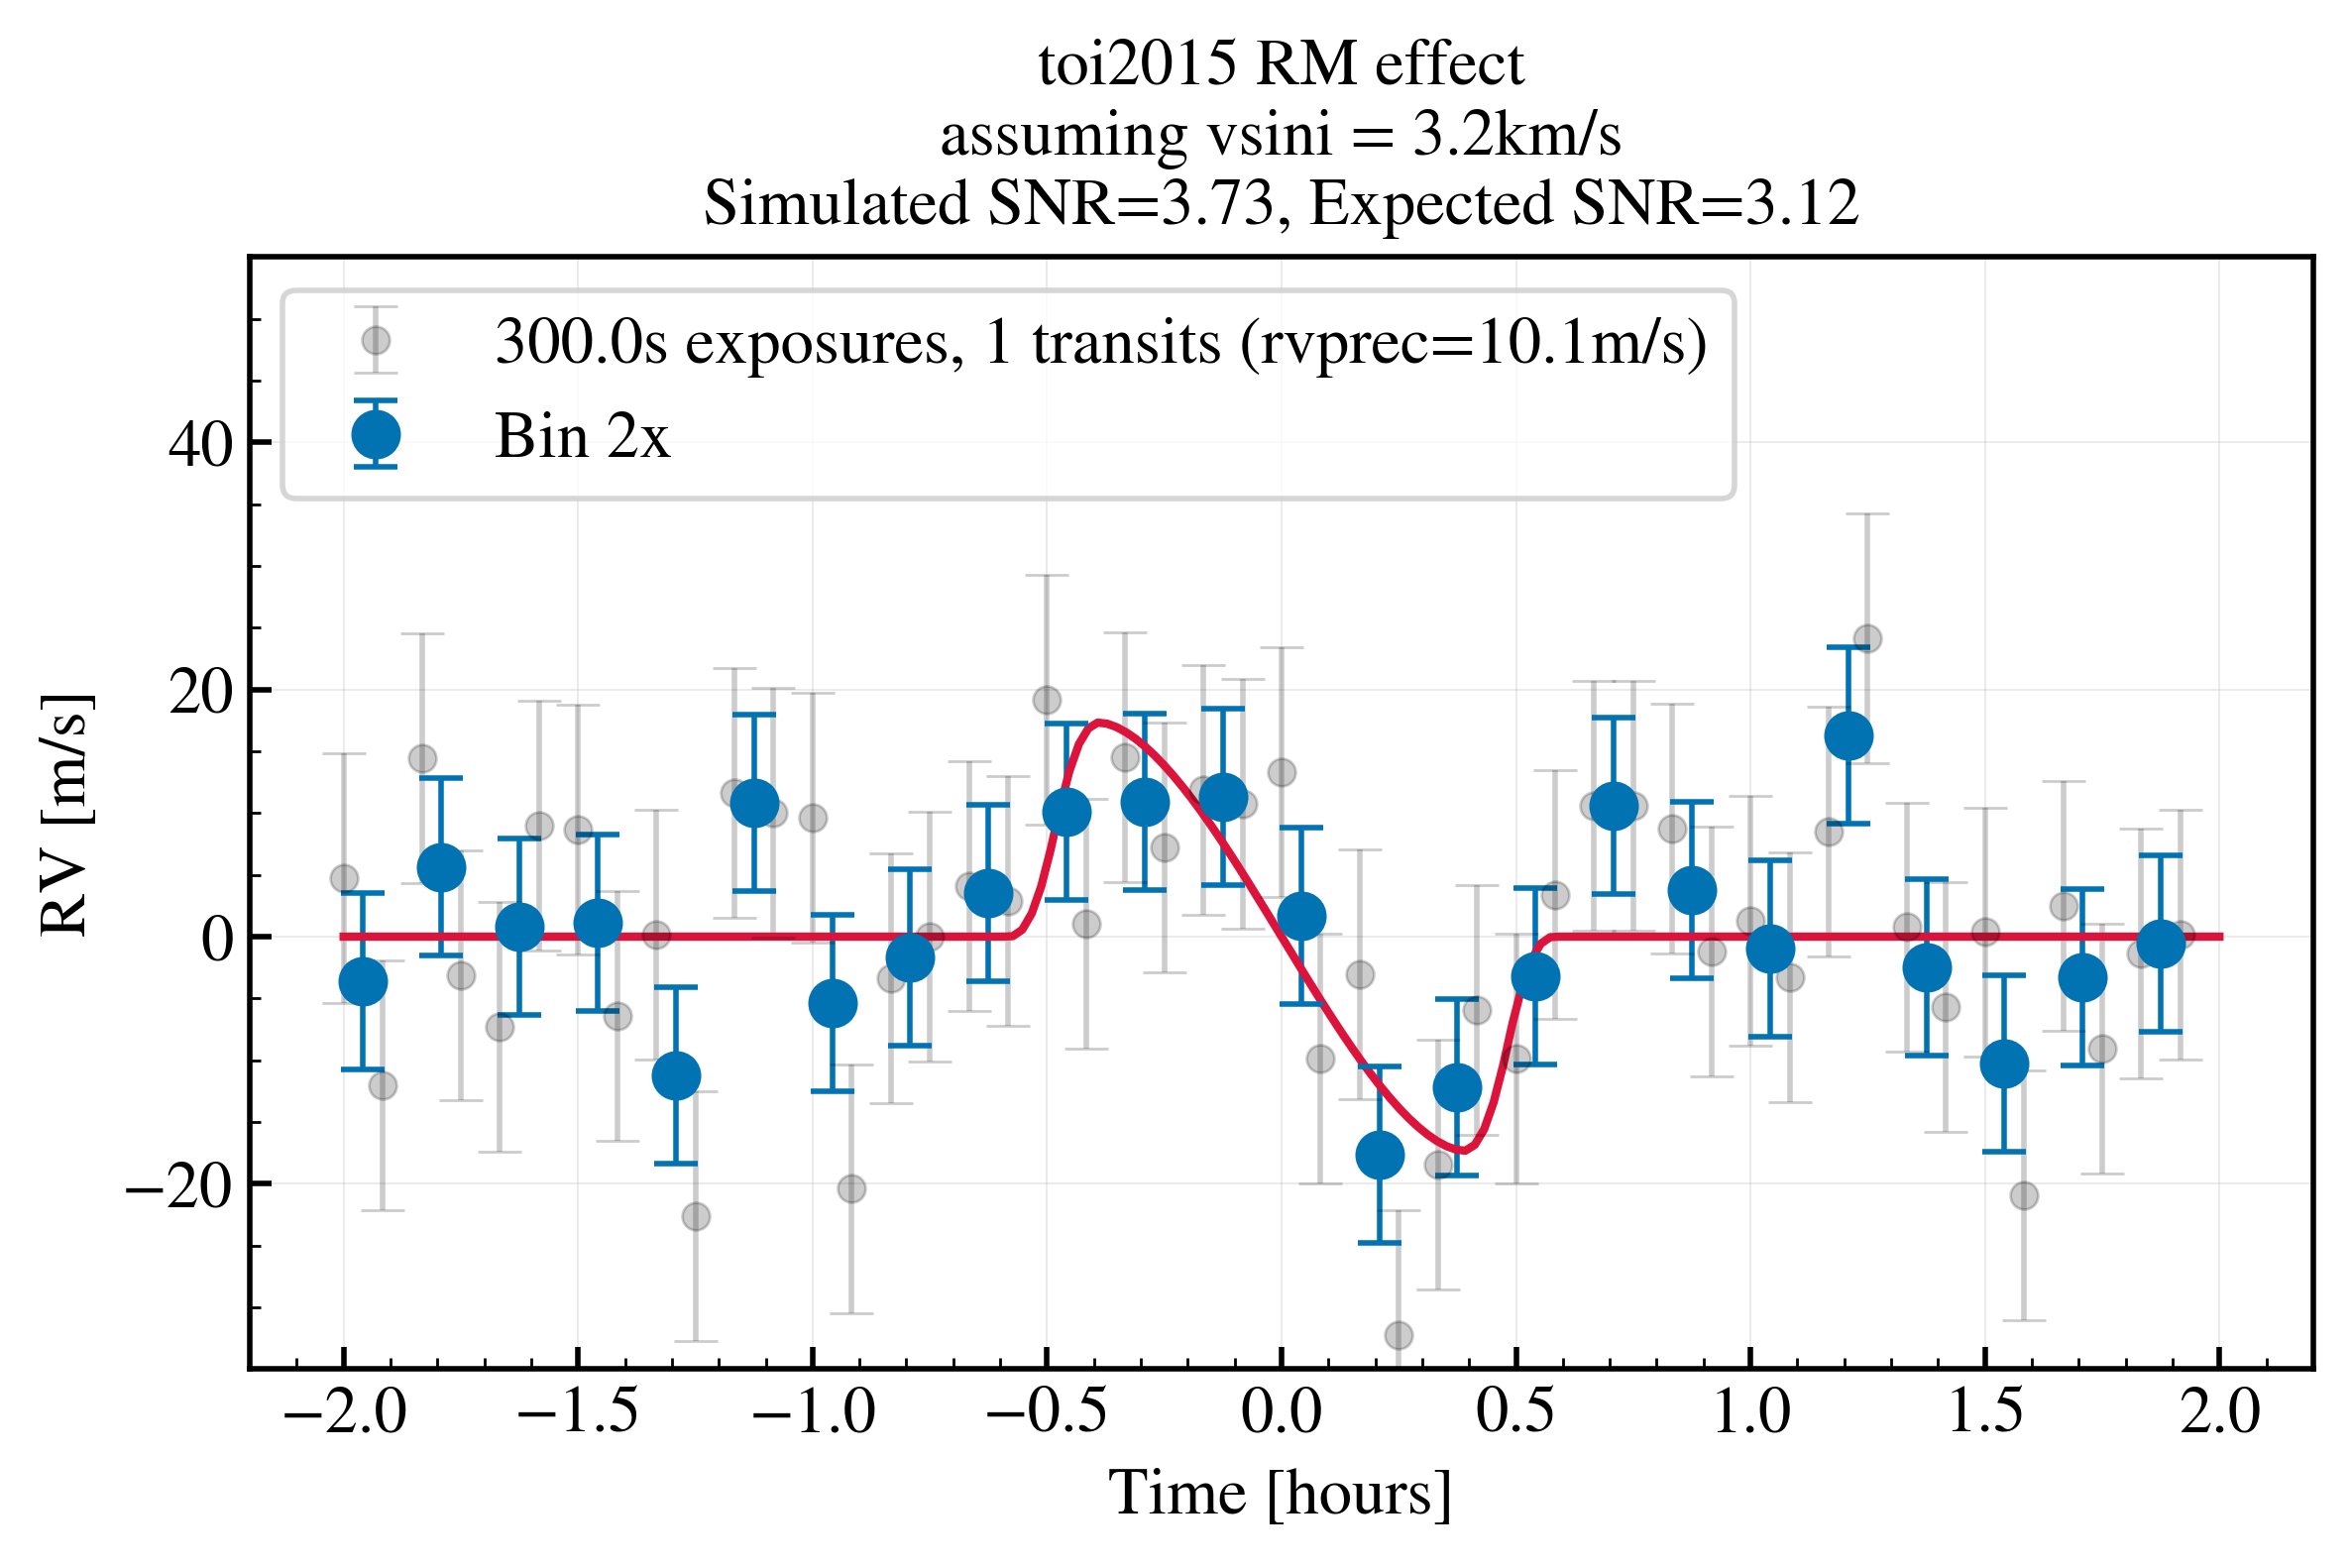

In [3]:
import astropylib.rm_models
TARGET = 'toi2015'
aRs = 24.
lam = 0.
eps = 0.5
u = [eps]
P = 3.345810
T0 = 0.
ii = 89.
IS = 90.
vsini = 3.2
rprs = 0.0906#np.sqrt(0.01)
rstar = 0.324
np.random.seed(1234)#1234#109#114
EXP = 300.
rvprec = 10.1
e = 0.0
omega = 90.
zbeta = 300000./110000
beta = np.sqrt(zbeta**2. + 3.**2.)
sigma = vsini/1.31

# ERROR AND OBSTIME
NTRANSITS = 1
NBIN = 2
error = rvprec/np.sqrt(NTRANSITS)#3.99/np.sqrt(4)#3.990*
exptime = EXP/86400.
x = np.linspace(-2./24,2./24,num=200)
_f = astropylib.exoplanet_functions.get_lc_batman(x,T0,P,ii,rprs,aRs,e,omega,u=[0.3,0.3],supersample_factor=1)
_m = _f < 1.
tdur = x[np.where(_m)[0][-1]]-x[np.where(_m)[0][0]]
num_in_transit = int(tdur/exptime)
print(tdur)

# Model
RH = astropylib.rm_models.RMHirano(lam,vsini,P,T0,aRs,ii,rprs,e,omega,u,rstar,beta,sigma,supersample_factor=7,exp_time=exptime,limb_dark='linear')
rm_hirano = RH.evaluate(x)
print('Amplitude: {}m/s'.format(np.max(rm_hirano)))

# Observed
x_obs = np.arange(-2./24,2./24,exptime)
errors = np.ones(len(x_obs))*error
rm_obs_hirano = RH.evaluate(x_obs,base_error=error)

fig, ax = plt.subplots(dpi=200)
ax.plot(x*24.,rm_hirano,color='crimson')
ax.errorbar(x_obs*24.,rm_obs_hirano,yerr=error,color="black",marker='o',lw=0,elinewidth=1,
            capsize=4,mew=0.5,label='{}s exposures, {} transits (rvprec={:0.1f}m/s)'.format(EXP,NTRANSITS,error),
            alpha=0.2)

# Binning w error
df_bin_err = astropylib.spec_help.bin_data_with_errors(x_obs,rm_obs_hirano,errors,NBIN)
ax.errorbar(df_bin_err.x*24.,df_bin_err.y,df_bin_err.yerr,color=cp[0],marker='o',lw=0,markersize=8,label='Bin {}x'.format(NBIN),elinewidth=1,capsize=4,mew=1)

ax.legend(loc="upper left",fontsize=12)
astropylib.gkastro.ax_apply_settings(ax)
ax.set_xlabel('Time [hours]',fontsize=12)
ax.set_ylabel('RV [m/s]',fontsize=12)
ax.set_title('TOI-2015.01 RM effect\nassuming vsini = {}km/s'.format(vsini),fontsize=12)
ax.set_ylim(-35,55)

# SNR
snr = astropylib.exoplanet_functions.rm_SNR(0,astropylib.exoplanet_functions.b_from_aRs_and_i(aRs,ii),num_in_transit,np.max(rm_hirano),error)
print("SNR: {}".format(snr))
err_lam = astropylib.exoplanet_functions.rm_sigma_lambda(0.,astropylib.exoplanet_functions.b_from_aRs_and_i(aRs,ii),num_in_transit,np.max(rm_hirano),error)
print("lambda error: {}".format(err_lam))
ax.set_title('TOI-2015.01 b RM effect\nassuming vsini = {}km/s\nExpected SNR={:0.2f}'.format(vsini,snr),fontsize=12)

res = rm_obs_hirano - astropylib.exoplanet_functions.get_rm_model(x_obs,aRs,lam,eps,P,T0,ii,IS,vsini,rprs,rstar,supersample_factor=7,exp_time=exptime,base_error=0.)
savename = '{}_vsini_{}_ntransits_{}.png'.format(TARGET,vsini,NTRANSITS)
print('###########')
print(savename)
print('###########')
SN = np.sqrt(astropylib.stats.chi2(rm_obs_hirano,error*np.ones(len(rm_obs_hirano)),2)-astropylib.stats.chi2(res,error*np.ones(len(rm_obs_hirano)),2))
ax.set_title('{} RM effect\nassuming vsini = {}km/s\nSimulated SNR={:0.2f}, Expected SNR={:0.2f}'.format(TARGET,vsini,SN,snr),fontsize=12)
print(SN,snr)
fig.tight_layout()
#fig.savefig(savename,dpi=200)
astropylib.gkastro.ax_set_linewidth(ax,1)

In [72]:
TF.lpf.ps_fixed.args1

[0.0, 90.0]

In [41]:
import rm
reload(rm)

<module 'rm' from '../src/rm.py'>

In [42]:
L = rm.LPFunction(x_obs,rm_obs_hirano,errors,'../data/priors.dat')
TF = rm.RMFit(L)

   prior       arg1      arg2     label description priortype  fixed
0     UP    0.00000    0.0006     t0_p1       t0_p1     model  False
1     NP    3.34581    0.0005      P_p1        P_p1     model  False
2     UP -180.00000  180.0000    lam_p1      lam_p1     model  False
3     NP    3.20000    0.5000     vsini       vsini     model  False
4     NP   89.00000    0.2000    inc_p1      inc_p1     model  False
5     NP    0.09060    0.0020      p_p1        p_p1     model  False
6     NP   24.00000    0.5000      a_p1        a_p1     model  False
7     NP    0.32400    0.0100     rstar       rstar     model  False
8     NP    0.50000    0.0500        u1          u1     model  False
9     UP  -30.00000   30.0000     gamma       gamma     model  False
10    FP    0.00000    0.0000    ecc_p1      ecc_p1     model   True
11    FP   90.00000   90.0000  omega_p1    omega_p1     model   True
12    NP    4.00000    0.5000     vbeta       vbeta     model  False
13    NP    2.50000    0.5000     

In [43]:
TF.minimize_PyDE(mcmc=False)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
    labels   centers      lower      upper            pv   center_dist
0    t0_p1   0.00030    0.00000    0.00060  1.903648e-08  2.999810e-04
1     P_p1   3.34581    3.34331    3.34831  3.345811e+00 -6.830707e-07
2   lam_p1   0.00000 -180.00000  180.00000  6.237531e+00 -6.237531e+00
3    vsini   3.20000    0.70000    5.70000  3.123313e+00  7.668710e-02
4   inc_p1  89.00000   88.00000   90.00000  8.902926e+01 -2.925637e-02
5     p_p1   0.09060    0.08060    0.10060  9.049418e-02  1.058194e-04
6     a_p1  24.00000   21.50000   26.50000  2.393188e+01  6.812065e-02
7    rstar   0.32400    0.27400    0.37400  3.239866e-01  1.335681e-05
8       u1   0.50000    0.25000    0.75000  5.021827e-01 -2.182668e-03
9    gamma   0.00000  -30.00000   30.00000  8.477069e-01 -8.477069e-01
10   vbeta   4.00000    1.50000    6.50000  4.006257e+00 -6.257483e-03
11   sigma   2.50000    0.00000    5.00000  2.444013e+00  5.598667e-02
LogPost value: 

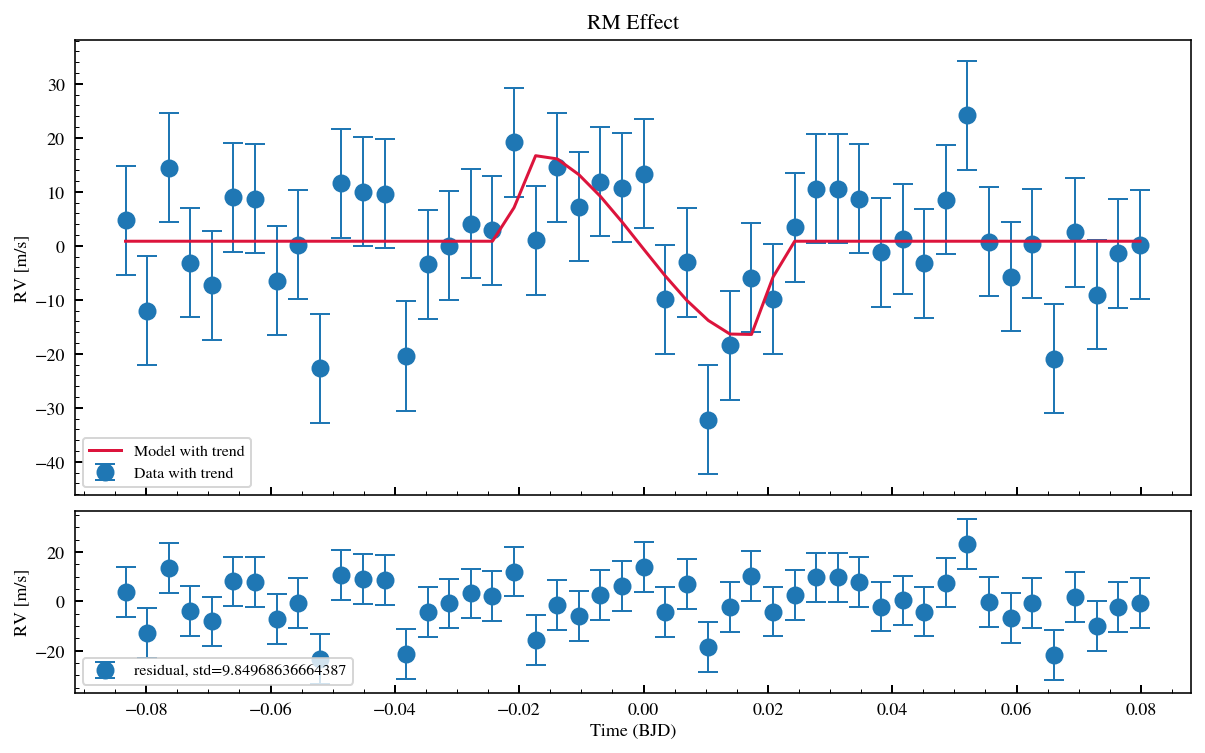

In [44]:
TF.plot_lc(TF.min_pv)

In [45]:
TF.minimize_PyDE(mcmc=True,mc_iter=200)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
    labels   centers      lower      upper            pv   center_dist
0    t0_p1   0.00030    0.00000    0.00060  1.988419e-08  2.999801e-04
1     P_p1   3.34581    3.34331    3.34831  3.345810e+00 -3.242069e-07
2   lam_p1   0.00000 -180.00000  180.00000  6.279961e+00 -6.279961e+00
3    vsini   3.20000    0.70000    5.70000  3.122629e+00  7.737089e-02
4   inc_p1  89.00000   88.00000   90.00000  8.902967e+01 -2.967140e-02
5     p_p1   0.09060    0.08060    0.10060  9.050007e-02  9.992887e-05
6     a_p1  24.00000   21.50000   26.50000  2.393263e+01  6.737442e-02
7    rstar   0.32400    0.27400    0.37400  3.240133e-01 -1.327526e-05
8       u1   0.50000    0.25000    0.75000  5.023937e-01 -2.393748e-03
9    gamma   0.00000  -30.00000   30.00000  8.515829e-01 -8.515829e-01
10   vbeta   4.00000    1.50000    6.50000  4.006504e+00 -6.504106e-03
11   sigma   2.50000    0.00000    5.00000  2.444148e+00  5.585215e-02
LogPost value: 

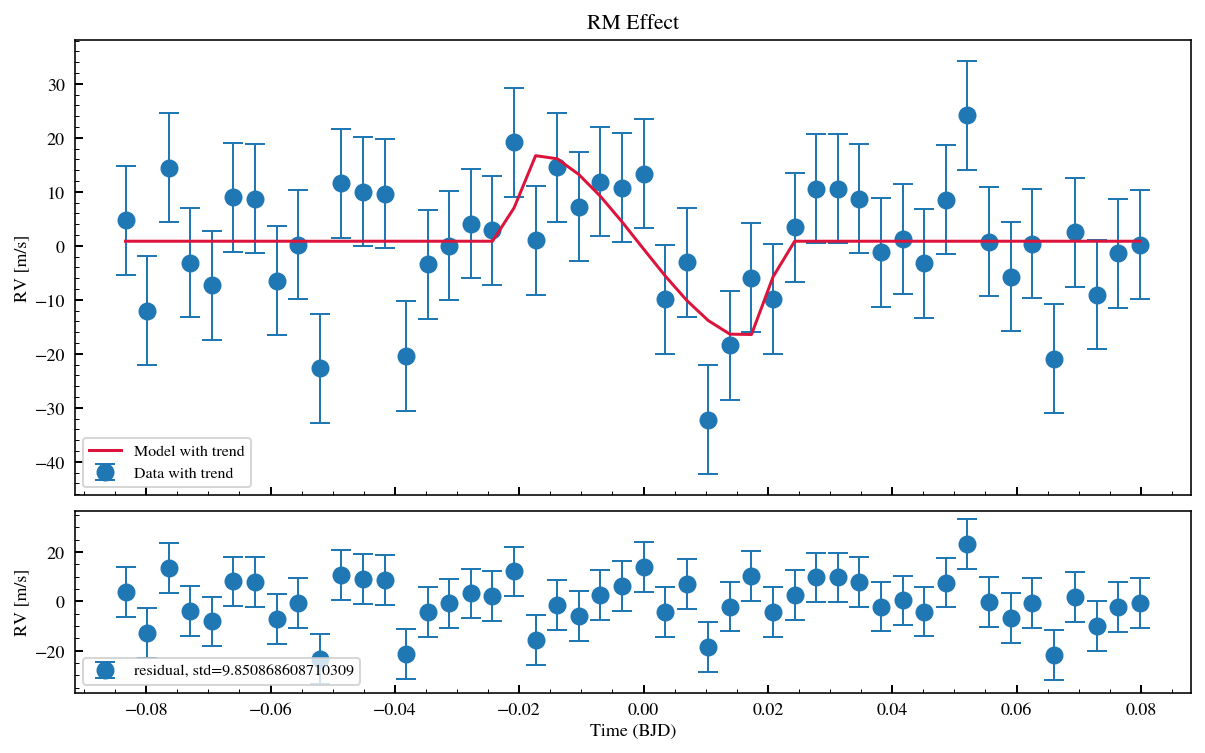

In [46]:
TF.plot_lc_mcmc_fit()

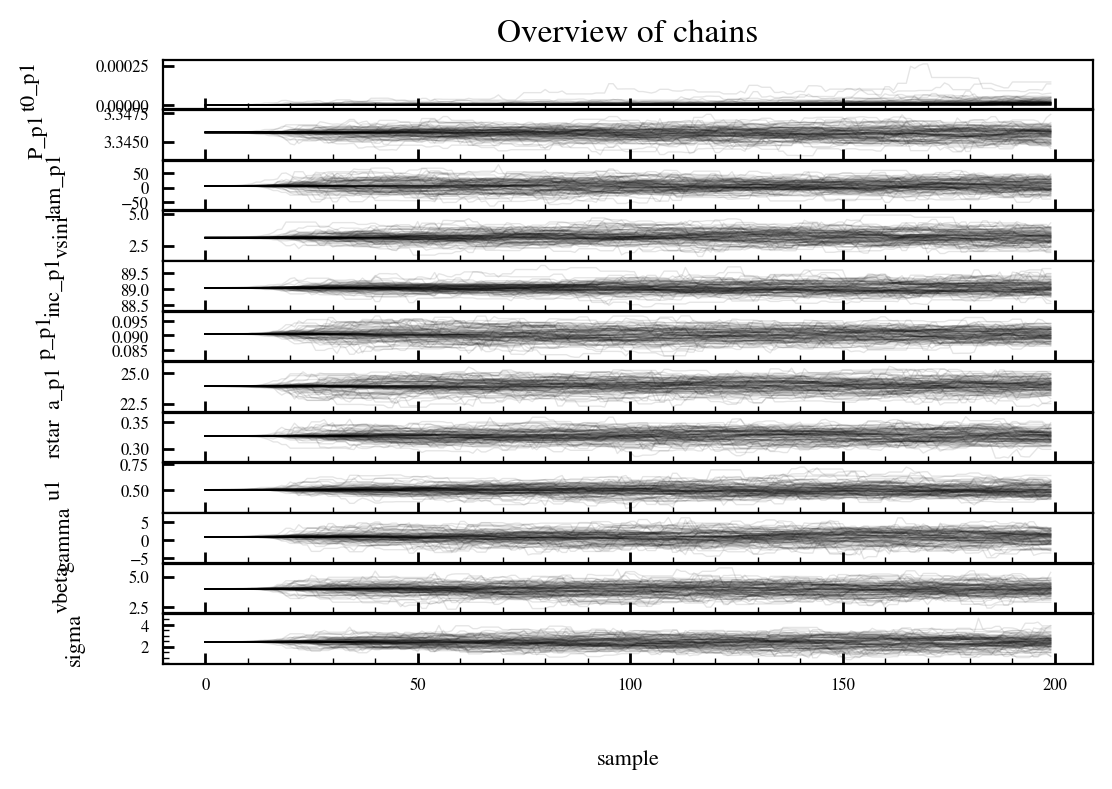

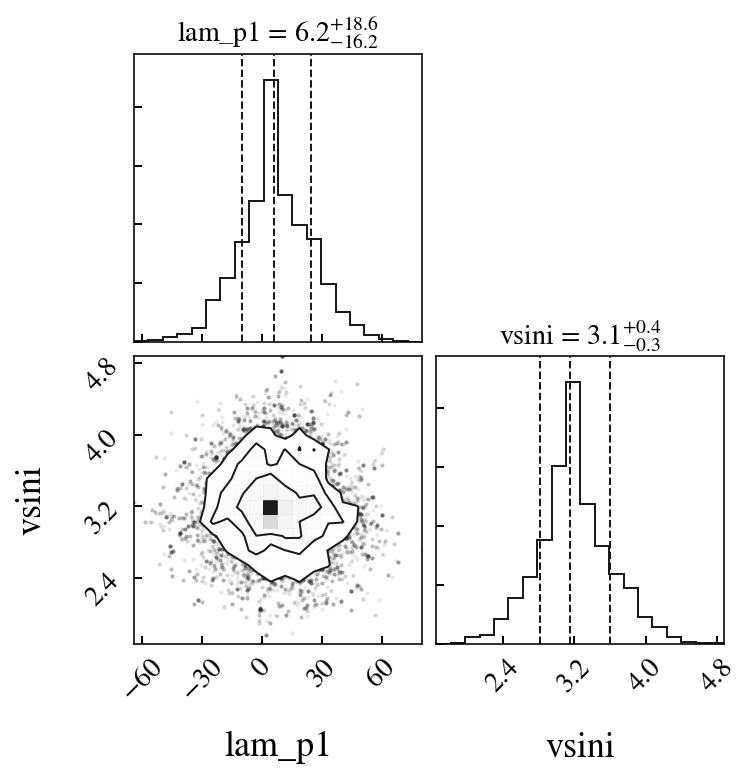

In [50]:
from astropylib import mcFunc
mcFunc.plot_chains(TF.sampler.chain,labels=TF.lpf.ps_vary.labels)
fig = astropylib.mcFunc.plot_corner(TF.sampler.chain[:,10:,[2,3]],
       show_titles=True,labels=np.array(TF.lpf.ps_vary.descriptions)[[2,3]],title_fmt='.1f',xlabcord=(0.5, -0.2))
